<a href="https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/lecture_2024/Psychometric_function_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psychometric function (PF)

__updated: Dec. 2024__

The psychometric function (PF) describes the relationship between human performance, such as classification, on a psychophysical task and sensory inputs like stimulus intensity. Recall that a general psychometric function:

$$\Psi(x,\alpha, \beta, \gamma, \lambda) = \gamma + (1-\gamma -\lambda) F(x, \alpha, \beta)$$

where $\alpha$ is the threshold, $\beta$ the discrmination sensitivity, $\gamma$ the chance level, and $\lambda$ the lapse rate.
Several candidate functions can be used for psychometric functions $F(x,\alpha, \beta)$:

* logit function
* cumulative Gaussian function
* Weibull

The Logit function is relatively simple:

$$ \log \frac{P}{1-P} = \beta(x-\alpha), $$
where $P$ represents the proportion of positive responses, and $1-P$ is the proportion of negative responses. The term $\log \frac{P}{1-P}$, also known as the log-likelihood of two alternative responses (ordecision variable), is modeled as a linear function of the stimulus intensity, $X$. This equation can be rewritten as:  

$$ P = \frac{1}{1+ e^{-\beta(x-\alpha)}}$$

From this formular, we can easily determine the __point of subjective equality__ (PSE, $\alpha$) and the __just noticeable difference__ (JND). The JND is defined as the difference between the thresholds at $P=0.5$ and $P=0.75$ (for 1AFC). It is given by

$$JND = \log3/\beta$$

This relationship shows that the slope $\beta$ becomes steeper, the JND decreases.

## Fitting the psychometric function

To fit generative psychometric functions, you can use libraries like `statsmodels`, `sklearn`, or `pingouin`. Additionally, specialized packages are available for this purpose, such as `python-psignifit` developed by Wichmann’s lab in Tübingen as a Python adaptation of their original MATLAB toolbox—and Bayesfit.

In this tutorial, we will primarily use the python-psignifit package. The concepts covered here can also be adapted to other packages, offering flexibility depending on your specific requirements.

For more detailed information about `python-psignifit, refer to its [official GitHub repository](https://github.com/wichmann-lab/python-psignifit).


## Usage of `Python-psignifit` package


Recall the session **Logistic regression**, we have introduced this package. Let's have a quick review on this.


In [ ]:
!pip install psignifit

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import psignifit as ps
import seaborn as sns

import matplotlib.pyplot as plt

# we creat one hypothetical data, first column (intensity), second column (number of correct trials), third column (number of total trials)
data = np.array([[0.0010,   45,   90],
                 [0.0015,   50,   90],
                 [0.0020,   44,   90],
                 [0.0025,   44,   90],
                 [0.0030,   52,   90],
                 [0.0035,   53,   90],
                 [0.0040,   62,   90],
                 [0.0045,   64,   90],
                 [0.0050,   76,   90],
                 [0.0060,   79,   90],
                 [0.0070,   88,   90],
                 [0.0080,   90,   90],
                 [0.0100,   90,   90]])



Second, you need a dictionary which allow you to change options for the fitting process.

In [ ]:
config = {
	'sigmoid': 'logistic',
	'experiment_type': '2AFC'
}

results = ps.psignifit(data, **config)
#output threshold
results.parameter_estimate

{'gamma': 0.5,
 'eta': 0.00015087126483529433,
 'lambda': 3.1531558203240214e-09,
 'threshold': 0.004634536661499031,
 'width': 0.0048302581622860115}

- `threshold`, the stimulus value of equal-odds

- `width`, the difference between the 5 and the 95 percentile of the unscaled sigmoid

- `lambda`, the lapse rate (upper asymptote of the sigmoid)

- `gamma`, the guess rate (lower asymptote of the sigmoid). This parameter is fixed for nAFC experiment types.

- `eta`,the overdispersion parameter. A value near zero indicates your data behaves binomially distributed, whereas values near one indicate severely overdispersed data.

Let's visualize the results.

The package also provide a basic plots - `psigniplot.plot_psychometric_function(result)`.

<Axes: xlabel='Stimulus Level', ylabel='Proportion Correct'>

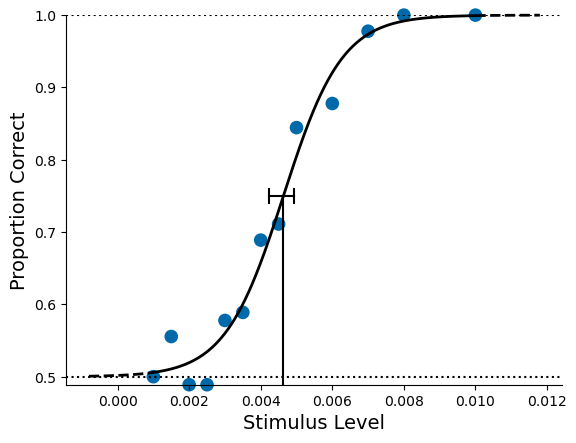

In [ ]:
from psignifit import psigniplot as pp
pp.plot_psychometric_function(results)

more plots can be found in the official document [here](https://psignifit.readthedocs.io/en/latest/examples/plotting.html)

## A case study: Temporal bisection

Recall in the lecture on 'logistic regression', we have used this example.

**Paper**:
Zhu, X., Baykan, C., Müller, H. J., & Shi, Z. (2021). Temporal bisection is influenced by ensemble statistics of the stimulus set. Attention, Perception & Psychophysics, 83(3), 1201–1214. https://doi.org/10.3758/s13414-020-02202-z

In this study we compare how ensemble statistics influence temporal bisection. We estimated the point of subjective equality (PSE) for each condition and use this PSE to judge if there are any significant changes in duration perception.

The results from Experiment 2 looks like this:

![](https://media.springernature.com/full/springer-static/image/art%3A10.3758%2Fs13414-020-02202-z/MediaObjects/13414_2020_2202_Fig3_HTML.png?as=webp)


The raw data are available in my github [here](https://raw.githubusercontent.com/msenselab/sets_in_bisection/master/data/AllData_exp2.csv).

In [ ]:
# Here the code we paractice last time
# Step 1: Prepare the data
bisection = pd.read_csv('https://raw.githubusercontent.com/msenselab/sets_in_bisection/master/data/AllData_exp2.csv')
mresp = bisection.groupby(['NSub', 'cond', 'curDur']).agg({'RP':'sum', 'NB':'count'}).reset_index()
mresp.columns = ['subj','condition', 'duration', 'correct','total']
mresp.head()

,subj,condition,duration,correct,total
0,1,1,0.4,2,126
1,1,1,0.6,6,108
2,1,1,0.8,49,90
3,1,1,1.0,64,72
4,1,1,1.2,54,54


In [ ]:
# 2. prepare for the psychometric function estimation
thresholds_df = []
# initialize the config dictionary
config = {
    'sigmoid': 'logistic',
    'experiment_type': 'yes/no' # short / long
}
# for illustration, we only fit two subjects (query('subj < 3'))
for (subj, context), group in mresp.query('subj < 3').groupby(['subj', 'condition']):
    #group contain the same columns as mresp
    data = group[['duration','correct','total']].to_numpy()

    res = ps.psignifit(data, **config)
    # Extract the threshold value
    threshold = res.parameter_estimate['threshold']
    thresholds_df.append({'subj':subj, 'context':context, 'threshold':threshold})

# convert the list of dictionaries to a data frame
thresholds_df = pd.DataFrame(thresholds_df)
thresholds_df.head()

,subj,context,threshold
0,1,1,0.802505
1,1,2,0.913571
2,2,1,0.730375
3,2,2,0.875113


__Note:__ The above logistic analysis  assumes the response curve is logistic curve is symmetrical. That is, the logistic function has the same guess rate $\gamma$ or lapse rate $\lambda$.

## Group Task

For group practice, we will use a recent published study:

Baykan, C., Zhu, X., Zinchenko, A., & Shi, Z. (2024). Blocked versus interleaved: How range contexts modulate time perception and its EEG signatures. Psychophysiology, 61(8), e14585. https://doi.org/10.1111/psyp.14585

The data of this study is available here: https://doi.gin.g-node.org/10.12751/g-node.7snfwg/

Your tasks are:

1. read raw data from their Experiment 1, and analyze psychometric functions for individual participants.
2. Extract the PSEs and JNDs and make statistical tests
3. Visualize group psychometric functions, replicating their Figure 2.

![fig. 2](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs00221-023-06670-1/MediaObjects/221_2023_6670_Fig2_HTML.png?as=webp)

### Step 1: Read raw data

In [ ]:
pd.options.mode.chained_assignment=None
# import data
# raw data from github
raw = pd.read_csv('https://gin.g-node.org/msense/EEG_bisection/raw/master/derivates/data/allData_exp1_beh.csv')
raw.head()

,Unnamed: 0,cond,RP,Exp,SubName,targetDur
0,1,PS,0,Exp1,sub-012,400
1,2,PS,0,Exp1,sub-012,504
2,3,PS,0,Exp1,sub-012,636
3,4,PS,1,Exp1,sub-012,1008
4,5,PS,1,Exp1,sub-012,1600


### Step 2: pivot table of Long Responses

Using `signifit` requires pivot table of 'correct' (long) responses for each condition. You should get similar tables as shown below:  

The data show two manipulated conditions: Positive Skew (PS) and Negative Skew (NS) sampled durations. The target duration (targetDur) ranged from 400 ms to 1600 ms. 'Long' responses were coded in the column `RP`, and subject ID in `SubName`.

In [ ]:
# your task is to form a table similar to the below, say you store in thresholds_df

,subj,condition,duration,Long,total
0,sub-001,NS,400,8,96
1,sub-001,NS,730,40,96
2,sub-001,NS,992,67,96
3,sub-001,NS,1200,86,96
4,sub-001,NS,1366,88,96


### Step 3: estimate psychometric functions

For each condition each participant, you need to estimate the threshold (PSE) and JND.

Tips: suppose you obtain a results from psignifit as `res`, you can get the threshold using `res.parameter_estimate['threshold']` for the PSE.
Additionally, we can get a threshold at any points. Recall that the JND = (Threshold_0.75 - Threshold_0.25)/2, we can use the following code to estimate the JND:

```python
low, CI = res.threshold(0.25, unscaled = True)
high, CI = res.threshold(0.75, unscaled = True)
JND = (high-low)/2
```


In [ ]:
# your task is to estimate thresholds and jnd and store in a table like the below

,subj,context,threshold,jnd
0,sub-001,NS,790.749348,190.557888
1,sub-001,PS,617.887938,174.712131
2,sub-002,NS,992.802512,134.640442
3,sub-002,PS,991.165315,179.951882
4,sub-003,NS,1528.942196,150.481332


### Step 4. Visualize the average psychometric functions, PSEs, JNDs

Your task is to replicate the original Figure 2.

In [ ]:
# first estimate two psychometric function results, say res_ps and res_ns


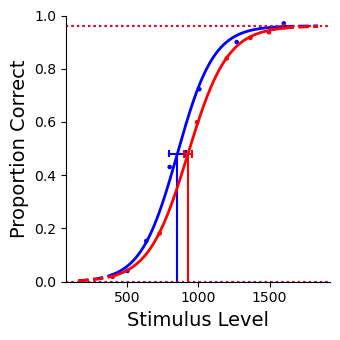

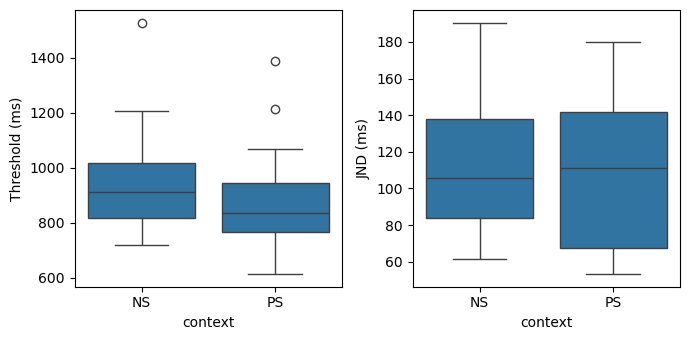

In [ ]:
# next visualize res_ps and res_ps for subplot 1
fig, ax1 = plt.subplots(1, 1, figsize = (3.5,3.5))
#plot the psychometric functions from above res_ps and res_ns
# Fix me here

# display the plots
plt.tight_layout()
plt.show()

# then plot the thresholds and JNDs from thresholds_df
fig, (ax2, ax3) = plt.subplots(1,2, figsize = (7, 3.5))
# boxplot for thresholds

#Fix ME

# boxplot for JNDs
#Fix me

# display the plots
plt.tight_layout()
plt.show()

In [ ]:
import pingouin as pg

# next do pairwise test for threshold
# Fix me


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,context,NS,PS,True,True,2.909891,18.0,two-sided,0.009344,5.505,0.383116


In [ ]:
# Fix me: pairwise t-test for JND

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,context,NS,PS,True,True,1.178502,18.0,two-sided,0.253942,0.435,0.14607
